# Nonlinear Elasticity in a multipatch domain


In [72]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

Populating the interactive namespace from numpy and matplotlib


In [73]:
p = 3  # spline degree 
n_el = (40,15)  #(40,15)# number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [74]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
geos = [
 
    geometry.quarter_annulus(r1=0.31, r2=0.4),
    geometry.quarter_annulus(r1=0.31, r2=0.4).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=0.31, r2=0.4).rotate_2d(pi),
    geometry.quarter_annulus(r1=0.31, r2=0.4).rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)

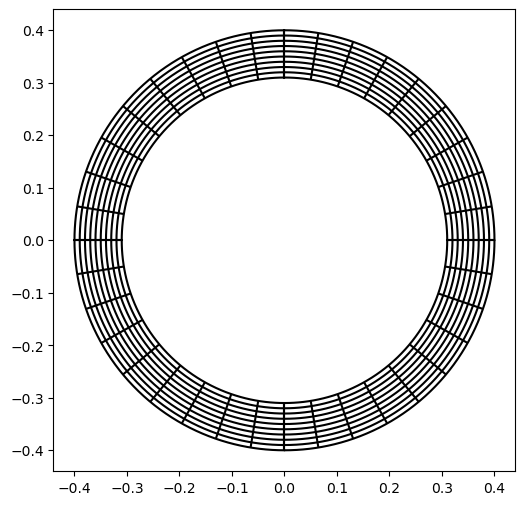

In [75]:
figsize(8,6)
for g in geos:
    vis.plot_geo(g)
axis('scaled');

In [76]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [77]:
# source term f 
def f(x, y): return (0.0, 0.0)

In [78]:
#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
def gN(x, y): 
    return (x/0.31*loading_value, y/0.31*loading_value)  #inner  pressure, normalized vector


#incremental loading
#loading = [1e-4, 1.5e-4, 2e-4, 2.5e-4, 3e-4]
loading = [5e-5, 6e-5, 7e-5, 8e-5, 9e-5, 1e-4] #, 1.25e-4] #, 2e-4]

# set loading_value (used in 1st iteration, lin. problem)
loading_value = loading[-1]
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 


In [79]:
# set Neumann data
#neu_data = [
#    (3,'right',gN) # left: inner radius/ right:outer radius
#]

# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )

In [80]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)
# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero )
])

In [81]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    ref = n_el[1]# take number of elements in y-dir  #OR: 15 # set manually!
    xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, xgrid)
    len_xgrid= len(xgrid)
    
    figsize(10,10)
    fig, ax = plt.subplots()
    
     # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-4)
    colorbar();
    axis('equal')


In [82]:
# Compute solution of nonlinear elasticity problem

In [83]:
#split the solution into its components (displacement in x- and y- direction) and convert to BSpline function
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [84]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)
# incompressible: Lam = 0


# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam* assemble.assemble('div(dis)*div(v) * dx+ 1/2 *tr( grad(dis).T *grad(dis)) *div(v)*dx + inner(div(dis)*grad(dis), grad(v))*dx + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v)) *dx'
                             , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    A_lin_lam = Lam* assemble.assemble('(inner( (div(dis) + 1/2 *tr( grad(dis).T *grad(dis) )) * grad(u), grad(v)) + div(u)*div(v) + tr( grad(dis).T *grad(u) ) * div(v) + inner( (div(u) + tr(grad(dis).T *grad(u)) ) * grad(dis), grad(v)) ) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_lam
    
    A_lin_mu = 2*Mu * assemble.assemble('(inner(1/2 * grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) + (1/2) * (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + 1/2 * grad(dis)*(grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_mu
    
    return A_lin_lam + A_lin_mu # matrix A



In [85]:
# assemble matrix A and rhs b for nonlinear elasticity problem
def ass_nonlinsystem(u, neu_data):
    first = True
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)

        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #kvs_uy, geo_uy = MP_block.multi_patches[1].patches[p]

        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form

        # The patch-local right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X) # for arbitrary rhs

        # The patch-local Neumann boundary data
        
        ##implemented normal vector
        #nv = assemble.assemble('inner(v, n) * ds', kvs_ux, bfuns=[('v', 2)], geo=geo_ux, boundary='left', layout='packed')
        #print(nv.sum(axis=(0,1)))
        
        for item in neu_data:
            if item[0]==p:
                # normal vector + deformation
                N_e   = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    #print(len(bdofs))
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        #N_e[c,i,0] += dis_u[i,0,c]# update normal component?
                        b_p[bdofs[i]+offset] += N_e[c,i,0]

        if first:
            A = X @ A_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            b += X @ b_p 
    
    return A, b

In [86]:
# elasticity problem
#linear problem = linearized problem (for development point x_0=(0...0) )
def grad_J(x): #nonlin function (rhs) # u
    # a(u,v)-l(v)
    u_p = x
    first = True
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        b_p= apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)

        b0_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() # rhs (0,0,...,0) for nbc

        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1])
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b0_p[bdofs[i]+offset] += N_e[c,i,0]           
        if first:
            grad_b = X @ (b_p- b0_p)#"Au-b"
            first = False
        else:
            grad_b += X @ (b_p- b0_p) 
            
    return grad_b


# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=1) for n in n_el) # constant basis vector for integration

def J(x): #energy functional
    u_p = x
    j_N = 0
    j = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis))) *v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_p = sum(j_lam + j_mu)
        
        for item in neu_data:
            if item[0]==p:
                N_e  = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis) 
                #print('N=',N_e)
                j_N += N_e.sum()

        j += (j_p - j_N)
        
    return j


In [87]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    print('Start line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        if alpha > 1: # alpha too big # alpha in(0,1)!
            print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
        else:
            #print('a=', alpha)
            phi_hat= phi(alpha)
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                print('  phi_hat=', phi_hat)
                print('  phi_0=', phi(0))
                print('  derphi_0=', derphi(0))
                if derphi(0) >= 0:
                    print('  no descent direction')
                
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
               # print('  delta=', delta)
                ## interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                print('alpha_int=', alpha)
            
            else: # alpha too small & not too big
                derphi_hat = derphi(alpha)
                if derphi_hat < sigma*derphi(0): # alpha too small
                    print('  alpha too small')
                    if alphainf: # true, alpha_R =inf
                        print('  alpha_R = inf')
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        print('  alpha_R < inf')
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    ## update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                
                else:
                    return alpha

      

In [88]:
def make_solver_orig(B, symmetric=False, spd=False):
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    if spd:
        symmetric = True
# Gauß'sche Eliminationsverfahren - LU Zerlegung (auch LR für left-right)
    if scipy.sparse.issparse(B):
        print('use SuperLU')
            # use SuperLU (unless scipy uses UMFPACK?) -- really slow!
        spLU = scipy.sparse.linalg.splu(B.tocsc(), permc_spec='NATURAL')
        M= scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=spLU.solve, matmat=spLU.solve)
        return M
# Cholesky Zerlegung: Matrix muss symmetrisch und positiv definit sein!                  
    else:
        if symmetric:
            print('use Cholesky')
            chol = scipy.linalg.cho_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
        else:
            print('Matrix is not symmetric')
            LU = scipy.linalg.lu_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.lu_solve(LU, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
   

In [89]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False) # for s. p.d matrix
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [90]:
def solve(matrix, vector):
    try:
        return make_solver(matrix).dot(vector)
    # cholesky --> takes spd matrix
    except LinAlgError:
        print('use Gradient direction') # matrix not positive definite
        return vector
        #return 10000*vector
        

In [91]:
# solve linearized system 
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)

#g_N = gN # set Neumann boundary force (via incremental loading) 
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 
    
### first iteration ###
A, b= ass_nonlinsystem(u, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
r0= np.linalg.norm(LS.b) # rhs of undeformed system
print('r0=', r0)

u_d = make_solver_orig(LS.A).dot(LS.b) 
u_d = LS.complete(u_d)
u += u_d

A, b= ass_nonlinsystem(u, neu_data)
LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

r= np.linalg.norm(LS.b) # compute residuum
print('residual = ', r)

###-----------------###--------------------###
# solution = [LS.restrict(u)]
# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)/np.sqrt(len(u_d))
###----------------###---------------------###

r0= 1.5231545770397771e-05
use SuperLU
residual =  2.3396550272441537e-06


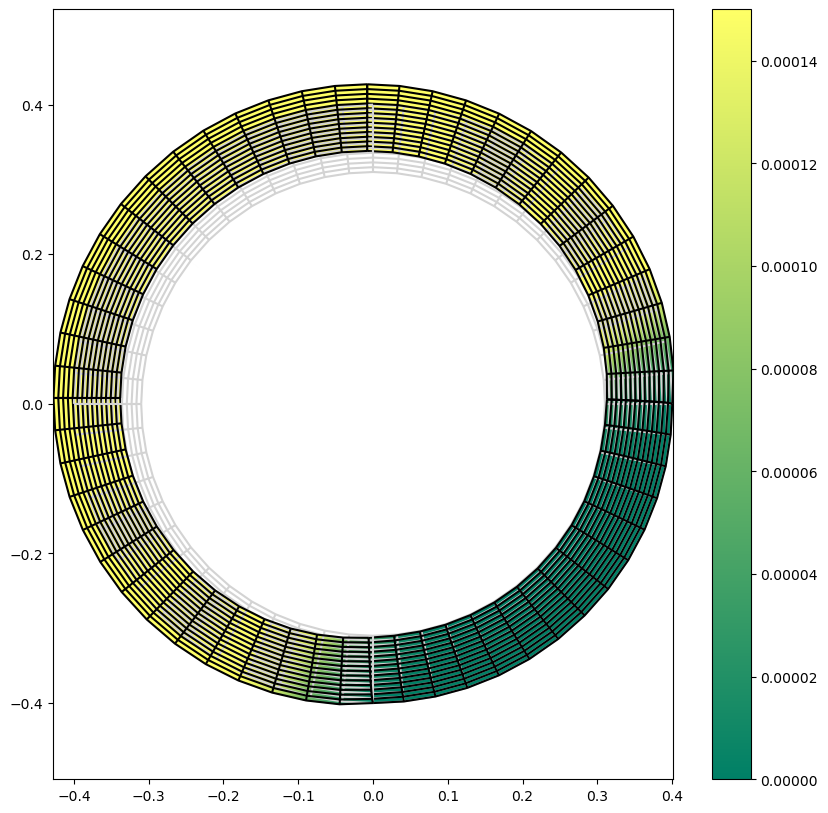

In [92]:
# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)

 
 
 1. loading: 5e-05 

1
use SuperLU
8.690608490782436e-07
Start line search
  0. alpha between 0 and None
  phi_hat= -1.3989173041636488e-06
  phi_0= -2.2191522642373745e-06
  derphi_0= -8.690608490782439e-07
alpha_int= 0.2572257754888158
  1. alpha between 0 and 1
  phi_hat= -2.0663055404908473e-06
  phi_0= -2.2191522642373745e-06
  derphi_0= -8.690608490782439e-07
alpha_int= 0.07638520824779169
  2. alpha between 0 and 0.2572257754888158
  phi_hat= -2.1780465231001418e-06
  phi_0= -2.2191522642373745e-06
  derphi_0= -8.690608490782439e-07
alpha_int= 0.02358707866877206
  3. alpha between 0 and 0.07638520824779169
  phi_hat= -2.2068471647252315e-06
  phi_0= -2.2191522642373745e-06
  derphi_0= -8.690608490782439e-07
alpha_int= 0.007369628373020162
  4. alpha between 0 and 0.02358707866877206
  phi_hat= -2.2153449039361244e-06
  phi_0= -2.2191522642373745e-06
  derphi_0= -8.690608490782439e-07
alpha_int= 0.0023109996981396375
alpha= None
residual =  3.7128859269579706e-06
2
use Super

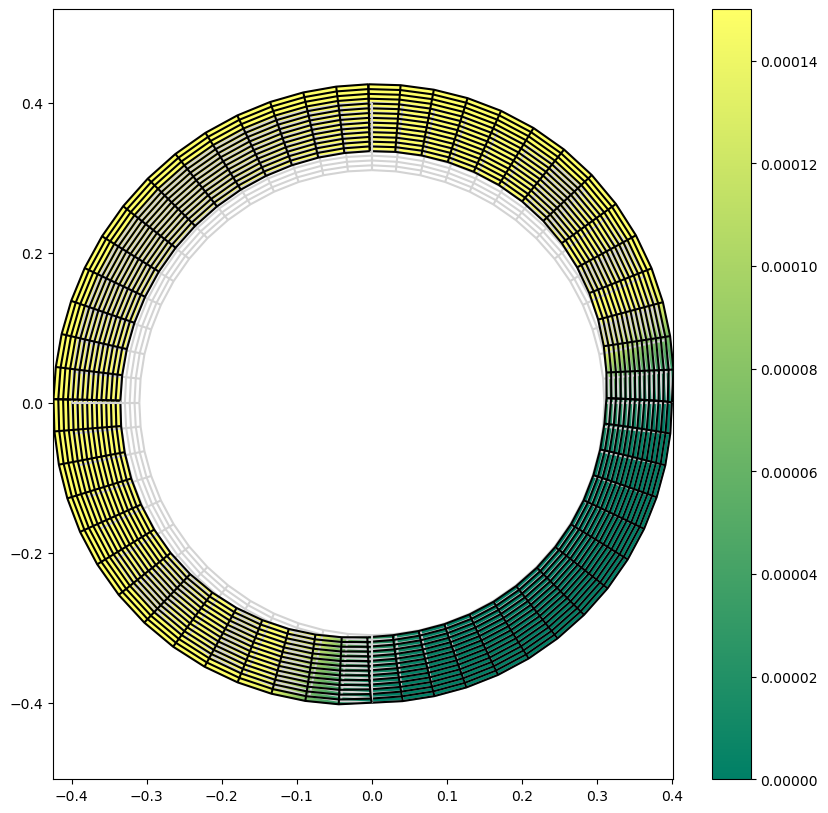

In [93]:
# solve linearized variational problem

epsilon= 1e-3 #1e-6

stepsizes =[] 
ud_array = []

# incremental loading # ----------------------------------
for i in range(len(loading)):
    print(" \n \n {}. loading: {} \n".format(i+1,loading[i]))
    
    # set Neumann data via incremental loading
    loading_value = loading[i]
    #g_N = gN 
    # neu_data = [(0,'right',g_N), (1,'right',g_N), (2,'right',g_N), (3,'right',g_N)] # outer radius
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # inner radius
    
    count= 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        A, b= ass_nonlinsystem(u,neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system

        # # solve system # #
        #u_d= solvers.make_solver(LS.A).dot(LS.b)
        u_d = make_solver_orig(LS.A).dot(LS.b) 

        # check if matrix is positive definite in a particular direction u_d
        if LS.b.dot(u_d) <= 0:
            print(LS.b.dot(u_d)) #transpose(LS.b)*M*LS.b
            print('Matrix is not positive definit! \n')
        else:
            print(LS.b.dot(u_d))

        # complete system dependent solution
        u_d = LS.complete(u_d)

        # # do Wolfe-Powell line search # # 
        alpha= Wolfe_LineSearch(J, grad_J, u, u_d) 
        #alpha= line_search(J, grad_J, u, u_d) # use integrated line search (scipy)
        print('alpha=', alpha)
        if alpha == None:
            u += 0.5 * u_d # alpha=0.5 (ignore line search)
        else:
            u += alpha * u_d

            
        # compute new non-linear residuum
        A, b = ass_nonlinsystem(u,neu_data)
        LS = assemble.RestrictedLinearSystem(A, b, bc) # solve linearized system
        r = np.linalg.norm(LS.b) # compute residuum
        print('residual = ', r)
        
        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = abs(normed_du0-normed_du)
        stepsizes.append(stepsize_du)
        normed_du0 = normed_du
        #---------------------------------------------------#

        if r < epsilon* r0: # break condition
            break
        elif count == 30:
            break

# print deformation plot
get_defplot(u, patches_u, kvs_u)

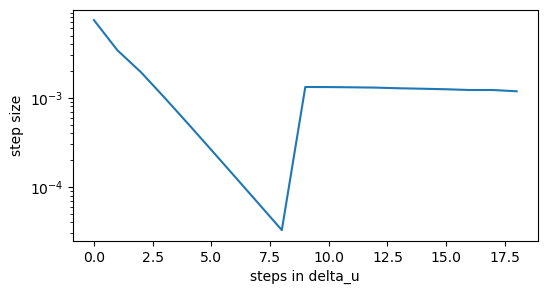

In [94]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');